In [ ]:
#  Intersection between enhancers

In [84]:
CELLS = ['GM12878', 'HepG2', 'K562', 'A549', 'H1']

In [85]:
import pandas as pd

# Read enhancers for all cells
df_enhancers = {}
for cell in CELLS:
    enh = pd.read_csv(f'data/{cell}_enhancers_hg38.bed', sep='\t', header=None)
    enh = enh.rename(columns={0: 'chrom', 1: 'start', 2: 'end', 3: 'score'})

    # Drop rows where chr has underscore
    enh = enh[~enh['chrom'].str.contains('_')]

    df_enhancers[cell] = enh

In [86]:
# parameters
origin_cell = 'H1'



In [87]:
df_enhancer = df_enhancers[origin_cell]

In [88]:
other_cells = [cell for cell in CELLS if cell != origin_cell]

In [89]:
# Read enhancers for all cells
df_mehyl_plus = {}
df_mehyl_minus = {}
for cell in CELLS:

    mehyl_plus = f'data/{cell}_wgbs_cpg_plus.bigWig'
    mehyl_minus = f'data/{cell}_wgbs_cpg_minus.bigWig'

    df_mehyl_plus[cell] = mehyl_plus
    df_mehyl_minus[cell] = mehyl_minus


In [90]:
# This is GRH38, get the sequence

hg38_path = '/home/solozabal/Documents/github/build-deepsea-training-dataset/data_hg38/hg38.fa'

In [91]:
from pyfaidx import Fasta

# Get the sequence
hg38 = Fasta(hg38_path)

def get_sequence(row):
    chrom = row[0]
    start = row[1]
    end = row[2]

    sequence = str(hg38[chrom][start:end])
    sequence = sequence.upper()

    return sequence

df_enhancer['sequence'] = df_enhancer.apply(get_sequence, axis=1)

/tmp/ipykernel_26994/3736724702.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = row[0]
/tmp/ipykernel_26994/3736724702.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = row[1]
/tmp/ipykernel_26994/3736724702.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = row[2]


<Axes: >

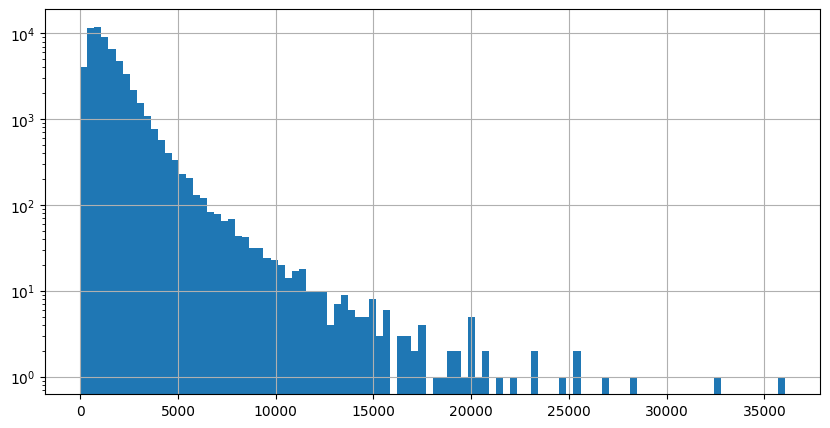

In [92]:
# histgram of length

df_enhancer['length'] = df_enhancer['end'] - df_enhancer['start']

# log scale
df_enhancer['length'].hist(bins=100, figsize=(10, 5), log=True)

In [93]:
# If enhancer > 100000 remove

df_enhancer = df_enhancer[df_enhancer['length'] < 100000]

In [94]:
# What are the CpG methylation levels
 
import pyBigWig
from tqdm import tqdm

def get_methylation_level(row, bw_plus, bw_minus):
    chrom = row[0]
    start = row[1]
    end = row[2]
    
    # Get the methylation level over the region
    methylation_plus = bw_plus.values(chrom, start, end)
    methylation_minus = bw_minus.values(chrom, start, end)
    
    return methylation_plus, methylation_minus


import numpy as np

def classify_cpgs(row, cell):

    methyl_count = {'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0, 'g-methyl': 0}

    for position in range(0, len(row['sequence'])-1):

        # Get methylation values at positions 3 and 4 (0-indexed)
        val_c = row[f'methyl_plus_{cell}'][position]
        val_g = row[f'methyl_minus_{cell}'][position+1]

        # Set threasholds
        threshold_down = 10
        threshold_up = 100 - threshold_down

        # Check if nan
        if np.isnan(val_c) or np.isnan(val_g):
            continue

        # Check for no methylation (both values are below the lower threshold)
        if val_c < threshold_down and val_g < threshold_down:
            methyl_count['no-methyl'] += 1
        
        # Check for cg methylation (both values are above the upper threshold)
        elif val_c > threshold_up and val_g > threshold_up:
            methyl_count['cg-methyl'] += 1
        
        # Check for only c methyl: C is high and G is low
        elif val_c > threshold_up and val_g < threshold_down:
            methyl_count['c-methyl'] += 1
        
        # Check for only g methyl: G is high and C is low
        elif val_g > threshold_up and val_c < threshold_down:
            methyl_count['g-methyl'] += 1
    
    return methyl_count


from tqdm.notebook import tqdm
# Apply the function to get methylation levels
for cell in tqdm(CELLS):

    bw_plus = pyBigWig.open(df_mehyl_plus[cell])
    bw_minus = pyBigWig.open(df_mehyl_minus[cell])

    methylation_levels = df_enhancer.apply( lambda row: get_methylation_level(row, bw_plus, bw_minus), axis=1)

    # Assign the values to the dataframe
    df_enhancer[f'methyl_plus_{cell}'] = methylation_levels.apply(lambda x: x[0])
    df_enhancer[f'methyl_minus_{cell}'] = methylation_levels.apply(lambda x: x[1])

    # pybigwig close
    bw_plus.close()
    bw_minus.close()

    # Classify
    df_enhancer[f'methylation_class_{cell}'] = df_enhancer.apply(lambda row: classify_cpgs(row, cell), axis=1)

    # Remove 
    df_enhancer = df_enhancer.drop(columns=[f'methyl_plus_{cell}', f'methyl_minus_{cell}'])



  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_26994/2525662458.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom = row[0]
/tmp/ipykernel_26994/2525662458.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  start = row[1]
/tmp/ipykernel_26994/2525662458.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end = row[2]
/tmp/ipykernel_26994/2525662458.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, intege

In [95]:
df_enhancer

,chrom,start,end,score,sequence,length,methylation_class_GM12878,methylation_class_HepG2,methylation_class_K562,methylation_class_A549,methylation_class_H1
0,chr1,694420,694950,15.760154,TATGACTAAAGGTGAATTCCAGAGCAACATTAAATGTTGTCCCTTT...,530,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0..."
1,chr1,698510,699160,19.016000,TTTCATGGAATCACAGTTCCATGTGGATGGGGAGGCCTCACAATCA...,650,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0..."
2,chr1,843600,843970,15.500808,CCTACTCACTCGAATCACTAGAGAATACCAAATAGGAATAGGAAGA...,370,"{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 2, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0..."
3,chr1,845270,846050,8.262514,GCAATGGCTCACAAGGTACTAGTGGAACCCCAGTAAGTTATCTCAG...,780,"{'no-methyl': 0, 'cg-methyl': 5, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 6, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 1, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 2, 'c-methyl': 0..."
4,chr1,891300,892490,13.201270,TATTTATTACTTCATTAAGAGCAAATAAATACTTTAAGAAAACCTT...,1190,"{'no-methyl': 1, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 6, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 7, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 1, 'c-methyl': 0..."
...,...,...,...,...,...,...,...,...,...,...,...
59618,chrY,19075454,19075934,8.027802,TAAAGCAAAGGGAGCTGTCAGAGAATCTTCATTTTCCCAGTGTCTT...,480,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 5, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 3, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 8, 'cg-methyl': 0, 'c-methyl': 0..."
59619,chrY,19567484,19567994,7.705359,GGGTTCCTGTCCAGAGGGGTAGAGAAGAGTGGCTGAGGGCGCGCCC...,510,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 24, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 6, 'cg-methyl': 0, 'c-methyl': 1...","{'no-methyl': 22, 'cg-methyl': 0, 'c-methyl': ..."
59620,chrY,19744554,19744664,8.369712,TGTAAAATAAGAATCACATTGTCTTTAATGACGCGCTGGTTCCTCC...,110,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 3, 'cg-methyl': 0, 'c-methyl': 0..."
59621,chrY,20575884,20576274,8.274048,AAGGTACTGCTGTAAGCCTCTGGGACTATACCTCGGCTTGCTCTGC...,390,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 17, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 15, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 18, 'cg-methyl': 0, 'c-methyl': ..."


In [96]:
# Intersecting with other cells

In [97]:
import numpy as np
from tqdm import tqdm


def intersection_cells(df_1, df_2):
    overlap_pairs = []

    # Find common chromosomes
    common_chroms = set(df_1['chrom']).intersection(set(df_2['chrom']))

    for chrom in tqdm(common_chroms):
        # Select intervals for the current chromosome
        intervals_1 = df_1[df_1['chrom'] == chrom]
        intervals_2 = df_2[df_2['chrom'] == chrom].sort_values('start')
        
        for _, row_1 in intervals_1.iterrows():
            start_1, end_1 = row_1['start'], row_1['end']
            length_1 = end_1 - start_1

            # Vectorized candidate selection for HepG2 intervals that might overlap
            candidates = intervals_2[(intervals_2['end'] > start_1) & (intervals_2['start'] < end_1)]
            if candidates.empty:
                continue
            
            # Convert candidate columns to NumPy arrays for fast arithmetic
            starts_2 = candidates['start'].values
            ends_2 = candidates['end'].values
            lengths_2 = ends_2 - starts_2
            
            # Compute the overlapping region vectorized
            overlap = np.minimum(end_1, ends_2) - np.maximum(start_1, starts_2)
            
            # Determine valid overlaps with at least 50% reciprocal overlap
            valid = (overlap > 0) & ((overlap / length_1 >= 0.5) & (overlap / lengths_2 >= 0.5))
            if not np.any(valid):
                continue
            
            # Add each valid overlap to the result list
            for start_2, end_2, ov in zip(starts_2[valid], ends_2[valid], overlap[valid]):
                overlap_pairs.append({
                    'chrom': chrom,
                    'start_1': start_1,
                    'end_1': end_1,
                    'start_2': start_2,
                    'end_2': end_2,
                    'overlap': ov
                })

    return pd.DataFrame(overlap_pairs)



In [98]:
for other_cell in other_cells:
    df_enhancer[f'enhancer_{other_cell}'] = False
    df_enhancer[f'overlap_enhancer_{other_cell}'] = np.nan
    
    intersections = intersection_cells(df_enhancers[origin_cell], df_enhancers[other_cell])

    for _, row in intersections.iterrows():
        chrom = row['chrom']
        start = row['start_1']
        end = row['end_1']

        df_enhancer.loc[(df_enhancer['chrom'] == chrom) & (df_enhancer['start'] == start) & (df_enhancer['end'] == end), f'enhancer_{other_cell}'] = True

        df_enhancer.loc[(df_enhancer['chrom'] == chrom) & (df_enhancer['start'] == start) & (df_enhancer['end'] == end), f'overlap_enhancer_{other_cell}'] = row['overlap']



100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


In [99]:
df_enhancer

,chrom,start,end,score,sequence,length,methylation_class_GM12878,methylation_class_HepG2,methylation_class_K562,methylation_class_A549,methylation_class_H1,enhancer_GM12878,overlap_enhancer_GM12878,enhancer_HepG2,overlap_enhancer_HepG2,enhancer_K562,overlap_enhancer_K562,enhancer_A549,overlap_enhancer_A549
0,chr1,694420,694950,15.760154,TATGACTAAAGGTGAATTCCAGAGCAACATTAAATGTTGTCCCTTT...,530,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...",False,NaN,False,NaN,False,NaN,False,NaN
1,chr1,698510,699160,19.016000,TTTCATGGAATCACAGTTCCATGTGGATGGGGAGGCCTCACAATCA...,650,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...",False,NaN,False,NaN,False,NaN,False,NaN
2,chr1,843600,843970,15.500808,CCTACTCACTCGAATCACTAGAGAATACCAAATAGGAATAGGAAGA...,370,"{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 2, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0...",True,370.0,False,NaN,False,NaN,True,370.0
3,chr1,845270,846050,8.262514,GCAATGGCTCACAAGGTACTAGTGGAACCCCAGTAAGTTATCTCAG...,780,"{'no-methyl': 0, 'cg-methyl': 5, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 6, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 1, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 2, 'c-methyl': 0...",False,NaN,False,NaN,False,NaN,False,NaN
4,chr1,891300,892490,13.201270,TATTTATTACTTCATTAAGAGCAAATAAATACTTTAAGAAAACCTT...,1190,"{'no-methyl': 1, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 6, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 7, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 1, 'c-methyl': 0...",False,NaN,False,NaN,False,NaN,True,1190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59618,chrY,19075454,19075934,8.027802,TAAAGCAAAGGGAGCTGTCAGAGAATCTTCATTTTCCCAGTGTCTT...,480,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 5, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 3, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 8, 'cg-methyl': 0, 'c-methyl': 0...",False,NaN,False,NaN,False,NaN,True,480.0
59619,chrY,19567484,19567994,7.705359,GGGTTCCTGTCCAGAGGGGTAGAGAAGAGTGGCTGAGGGCGCGCCC...,510,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 24, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 6, 'cg-methyl': 0, 'c-methyl': 1...","{'no-methyl': 22, 'cg-methyl': 0, 'c-methyl': ...",False,NaN,False,NaN,False,NaN,False,NaN
59620,chrY,19744554,19744664,8.369712,TGTAAAATAAGAATCACATTGTCTTTAATGACGCGCTGGTTCCTCC...,110,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 3, 'cg-methyl': 0, 'c-methyl': 0...",False,NaN,True,110.0,False,NaN,True,110.0
59621,chrY,20575884,20576274,8.274048,AAGGTACTGCTGTAAGCCTCTGGGACTATACCTCGGCTTGCTCTGC...,390,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 17, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 15, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 18, 'cg-methyl': 0, 'c-methyl': ...",False,NaN,False,NaN,False,NaN,False,NaN


In [100]:
# Check DNAse in target cell
from intervaltree import Interval, IntervalTree

for other_cell in CELLS:

    df_target_dnase = pd.read_csv(f'data/{other_cell}_dnase.bed', sep='\t', header=None)
    

    # Create a dictionary to store an interval tree for each chromosome
    dnase_trees = {}

    # Assuming df_target_dnase has columns 'chromosome', 'start', and 'end'
    for idx, row in df_target_dnase.iterrows():
        chrom = row[0]
        start = row[1]
        end = row[2]
        if chrom not in dnase_trees:
            dnase_trees[chrom] = IntervalTree()
        dnase_trees[chrom].add(Interval(start, end))

    # Function to find overlapping DNase regions for a given chromosome
    def find_dnase_overlaps(chrom, start, end):
        if chrom in dnase_trees:
            return dnase_trees[chrom][start:end]
        else:
            return []  # No data available for the chromosome

    # Assuming df_enhancer has columns 'chromosome', 'start', and 'end'
    df_enhancer[f'dnase_{other_cell}'] = df_enhancer.apply(lambda row: find_dnase_overlaps(row['chrom'], row['start'], row['end']), axis=1)

    # True of False if there is an overlap
    df_enhancer[f'dnase_{other_cell}'] = df_enhancer[f'dnase_{other_cell}'].apply(lambda x: len(x) > 0)

In [101]:
df_enhancer

,chrom,start,end,score,sequence,length,methylation_class_GM12878,methylation_class_HepG2,methylation_class_K562,methylation_class_A549,...,overlap_enhancer_HepG2,enhancer_K562,overlap_enhancer_K562,enhancer_A549,overlap_enhancer_A549,dnase_GM12878,dnase_HepG2,dnase_K562,dnase_A549,dnase_H1
0,chr1,694420,694950,15.760154,TATGACTAAAGGTGAATTCCAGAGCAACATTAAATGTTGTCCCTTT...,530,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...",...,NaN,False,NaN,False,NaN,False,False,False,False,False
1,chr1,698510,699160,19.016000,TTTCATGGAATCACAGTTCCATGTGGATGGGGAGGCCTCACAATCA...,650,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...",...,NaN,False,NaN,False,NaN,False,False,False,False,False
2,chr1,843600,843970,15.500808,CCTACTCACTCGAATCACTAGAGAATACCAAATAGGAATAGGAAGA...,370,"{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 2, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...",...,NaN,False,NaN,True,370.0,False,False,False,False,False
3,chr1,845270,846050,8.262514,GCAATGGCTCACAAGGTACTAGTGGAACCCCAGTAAGTTATCTCAG...,780,"{'no-methyl': 0, 'cg-methyl': 5, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 6, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 3, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 1, 'c-methyl': 0...",...,NaN,False,NaN,False,NaN,False,False,False,False,True
4,chr1,891300,892490,13.201270,TATTTATTACTTCATTAAGAGCAAATAAATACTTTAAGAAAACCTT...,1190,"{'no-methyl': 1, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 6, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 7, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...",...,NaN,False,NaN,True,1190.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59618,chrY,19075454,19075934,8.027802,TAAAGCAAAGGGAGCTGTCAGAGAATCTTCATTTTCCCAGTGTCTT...,480,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 5, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 3, 'cg-methyl': 0, 'c-methyl': 0...",...,NaN,False,NaN,True,480.0,False,False,False,False,False
59619,chrY,19567484,19567994,7.705359,GGGTTCCTGTCCAGAGGGGTAGAGAAGAGTGGCTGAGGGCGCGCCC...,510,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 24, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 6, 'cg-methyl': 0, 'c-methyl': 1...",...,NaN,False,NaN,False,NaN,False,False,False,False,False
59620,chrY,19744554,19744664,8.369712,TGTAAAATAAGAATCACATTGTCTTTAATGACGCGCTGGTTCCTCC...,110,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 2, 'cg-methyl': 0, 'c-methyl': 0...",...,110.0,False,NaN,True,110.0,False,False,False,False,True
59621,chrY,20575884,20576274,8.274048,AAGGTACTGCTGTAAGCCTCTGGGACTATACCTCGGCTTGCTCTGC...,390,"{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 17, 'cg-methyl': 0, 'c-methyl': ...","{'no-methyl': 0, 'cg-methyl': 0, 'c-methyl': 0...","{'no-methyl': 15, 'cg-methyl': 0, 'c-methyl': ...",...,NaN,False,NaN,False,NaN,False,True,False,False,False


In [102]:
# Save the data
df_enhancer.to_csv(f'processed/{origin_cell}_enhancers_v2.csv', sep='\t', index=False)

